### If running within a Docker, no action is needed. If not, add the installation path (e.g. 'path_to_fwi2d_directory/local/bin') to the environment variables 'PATH' and 'PYTHONPATH' before running the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seppy

sep = seppy.sep()

In [5]:
# Create a directory to store data
!mkdir -p data
datapath = "./data/"

### Generate source time function (Ricker wavelet)
(can also be done directly in python)

In [3]:
# For an auxiliary program, running the executable without parameters will print its documentation
!GENERATE_WAVELET.x


Description:
   Generate a 1D wavelet.

Input/Output:
   Provide input as 'input=file.H' or '< file.H' and output as 'output=file.H' or '> file.H'.  '<' and '>' are valid for SEPlib format only.
   Input is required only if the wavelet is built from a provided amplitude spectrum.

Parameters:
   type - string - ['ricker']:
		options: 'ricker', 'gaussian', 'sinc', 'butterworth', 'exponential', 'bandpass','spectrum','power'.
   wc - 0<=float<=1 - [0.1]:
		central frequency for Ricker wavelet, given in fraction of the Nyquist.
   sigma - float - [1]:
		standard deviation (or damping) in axis units for Gaussian wavelet (or exponential wavelet)
   low_cutoff - 0<=float<=1 - [0]:
		low cutoff frequency for sinc and Butterworth wavelets, given in fraction of the Nyquist.
   high_cutoff - low_cutoff<=float<=1 - [0]:
		high cutoff frequency for sinc and Butterworth wavelets, given in fraction of the Nyquist.
   half_order - int - [2]:
		half of the order used in the default IIR Butterworth.
  

In [7]:
!GENERATE_WAVELET.x nt=1001 type=ricker dt=0.004 wc=0.1 datapath=${PWD}/data/ output=./data/wavelet.H

In [8]:
# peek into the description file of that wavelet
!cat ./data/wavelet.H



GENERATE_WAVELET.x:   nmbader@vision   Wed May 10 17:25:48 2023
		esize=4
		n1=1001
		o1=4.59135e-41
		d1=0.004
		label1=""
		sets next: in="/net/server/sep/nmbader/thesis/code/fwi2d/examples/data/wavelet.H@"
		data_format="xdr_float"


In [37]:
# load, and plot
axes_wavelet, data = sep.read_file(datapath+"wavelet.H")
wavelet = data.reshape(axes_wavelet.n,order='F').T

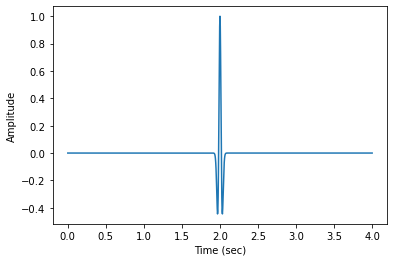

In [38]:
nt=axes_wavelet.n[0]
dt=axes_wavelet.d[0]
ot=axes_wavelet.o[0]
plt.plot(np.linspace(ot,(nt-1)*dt,nt),wavelet)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

### Generate a simple acoustic model
axes are (from left to right indices), axis 0: component (velocity, density) ; axis 1: x-axis ; axis 2: z-axis (depth oriented downwards)

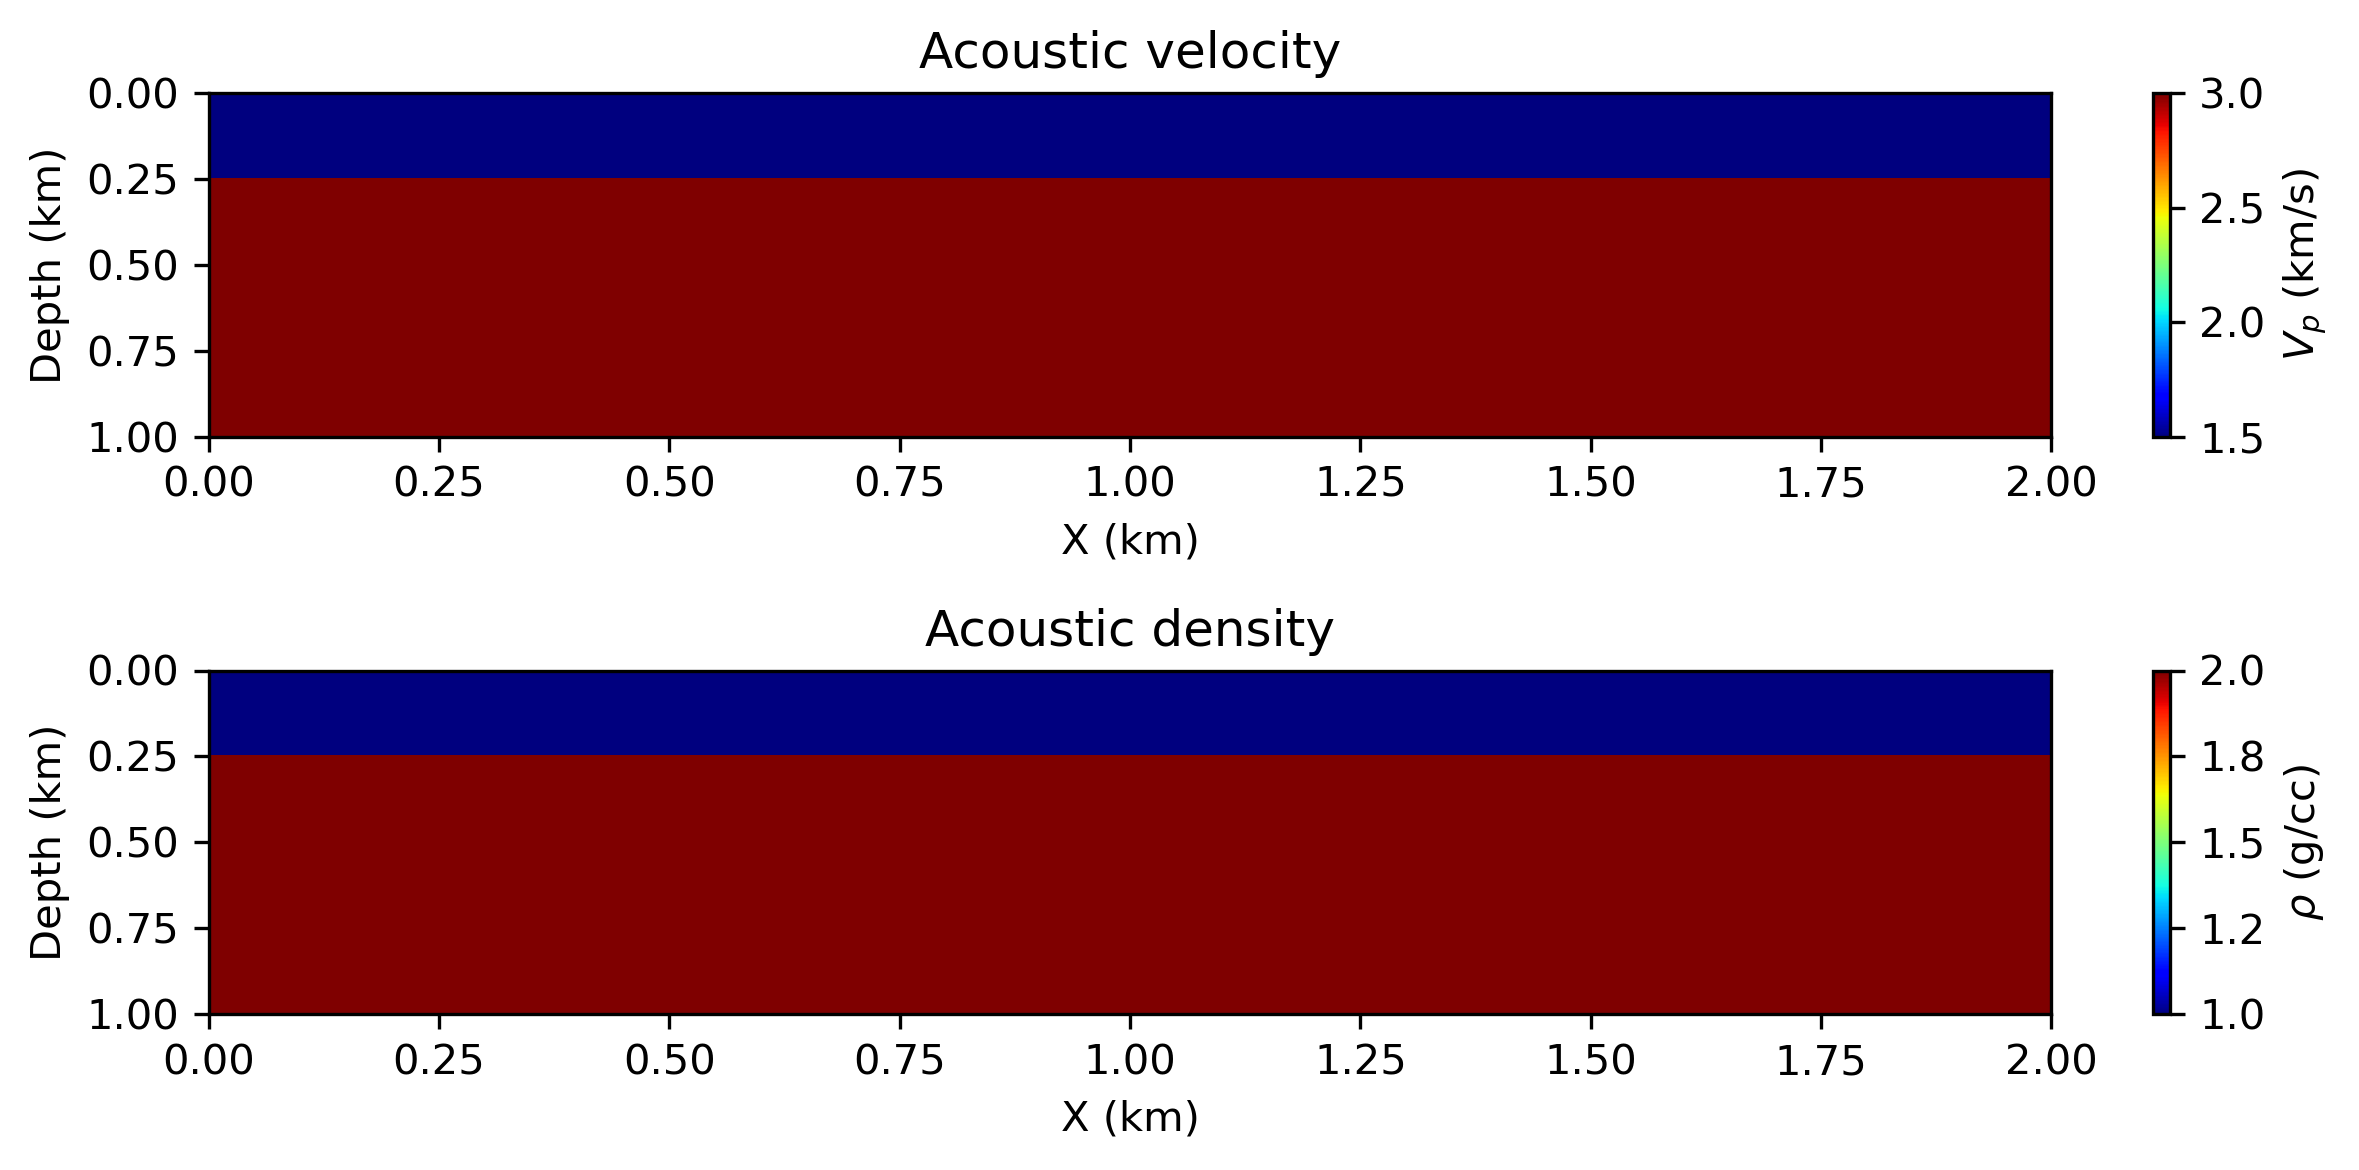

In [12]:
amodel=np.zeros((2,201,101))
amodel[0,:,0:25]=1.5 # Vp in km/s
amodel[0,:,25:]=3
amodel[1,:,0:25]=1 # # Density in g/cc
amodel[1,:,25:]=2

plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,1,1)
plt.imshow(np.transpose(amodel[0,:,:]),interpolation='none',aspect="auto",extent=[0,2,1,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Acoustic velocity")

plt.subplot(2,1,2)
plt.imshow(np.transpose(amodel[1,:,:]),interpolation='none',aspect="auto",extent=[0,2,1,0],cmap='jet')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Acoustic density")

plt.tight_layout()

In [13]:
# save the model in SEPlib format
dx=0.01 # in km
dz=0.01 # in km
ox=0 # in km 
oz=0 # in km 
sep.write_file(datapath+"amodel.H", np.transpose(amodel), ds=np.array([dz,dx,1]), os=np.array([oz,ox,0]), dpath=datapath)

### Forward modeling
The modeling parameters can be provided via a parameter file (as below) but they can also be given directly inline. A combination of the two is also admissible but the command line arguments will override the parameter file if the same parameter is provided in both. Check the parameter file for a description of each parameter. Input and output files must be provided directly inline. The full wavefield can also be output.

The log information can be saved into a file. By default it will print to the command line.

In [39]:
# peek into the parameter file
!cat ./par/acoustic_modeling.p

# time parameters, default are usually good
courant=0.6
dt=-1
fmax=30
resampling=sinc
sinc_half_length=11
sub=20

# sources and receivers geometry
ns=1
nr=101
sx0=1
sz0=0.1
rx0=0.5
rz0=0.2
rxinc=0.01
rzinc=0

# receiver type
seismotype=0

# boundary parameters
bc_top=1
bc_bottom=2
bc_left=2
bc_right=2
taper_top=0
taper_left=30
taper_right=30
taper_bottom=30
taper_strength=0.05

# model bounds
vpmin=0.2
vpmax=8
rhomin=0 
rhomax=8

# miscallenous
device=0
nthreads=24
verbose=3
format=0

In [40]:
# run the modeling
!WE_MODELING.x source=./data/wavelet.H model=./data/amodel.H output=./data/acoustic_data.H wavefield=./data/acoustic_wavefield.H datapath=${PWD}/data/ parfile=./par/acoustic_modeling.p

--------------------------------------------------------------------------
[[42962,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0

Wed May 10 17:44:53 2023


 Subsurface model geometry
xmin=0.00000 km, xmax=2.00000 km, dx=0.01000 km, nx=201
zmin=0.00000 km, zmax=1.00000 km, dz=0.01000 km, nz=101

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 30	 taper type = cosine squ

In [41]:
# load, and plot
axes_data, data = sep.read_file(datapath+"acoustic_data.H")
acoustic_data = data.reshape(axes_data.n,order='F').T

axes_wfld, data = sep.read_file(datapath+"acoustic_wavefield.H")
acoustic_wavefield = data.reshape(axes_wfld.n,order='F').T

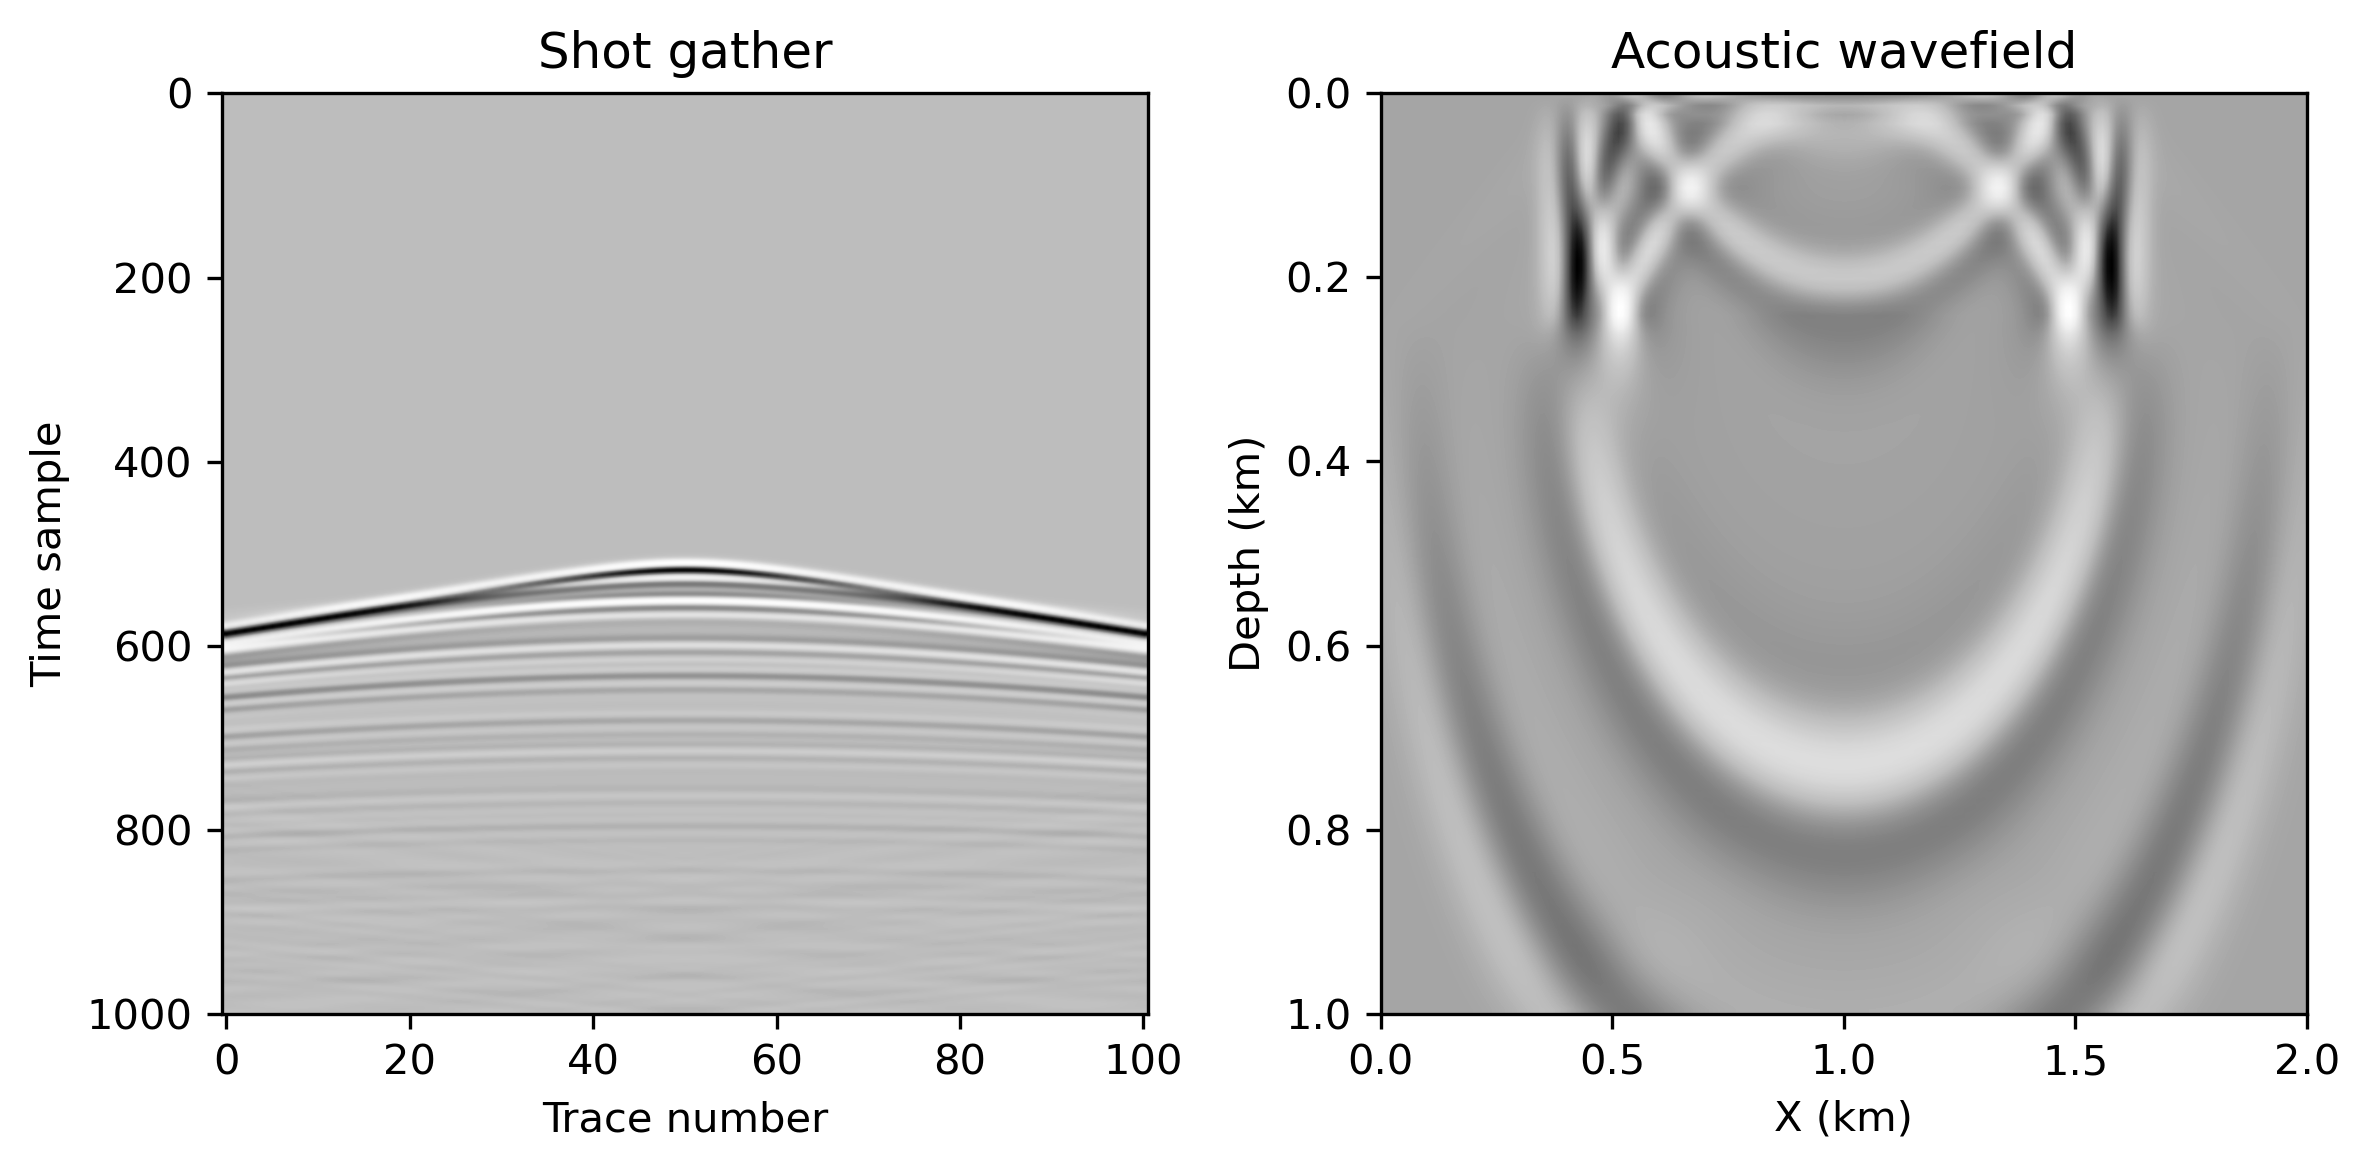

In [43]:
plt.figure(figsize=(8,4),dpi=300)
plt.subplot(1,2,1)
plt.imshow(np.transpose(acoustic_data[:,:]),interpolation='bilinear',aspect="auto",cmap='Greys')
plt.xlabel('Trace number')
plt.ylabel('Time sample')
plt.title("Shot gather")

it=60
xmin=axes_wfld.o[1]
zmin=axes_wfld.o[0]
xmax=(axes_wfld.n[1]-1)*axes_wfld.d[1] + xmin
zmax=(axes_wfld.n[0]-1)*axes_wfld.d[0] + zmin
plt.subplot(1,2,2)
plt.imshow(np.transpose(acoustic_wavefield[it,:,:]),interpolation='bilinear',aspect="auto",extent=[xmin,xmax,zmax,zmin],cmap='Greys')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.title("Acoustic wavefield")

plt.tight_layout()

Clean up the data directory

In [44]:
!rm -rf data